In [4]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
ALPUB_PATH = '../../Datasets/alpub_v2/images'

In [6]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [13]:
Y.shape

(205797, 24)

In [14]:
X.shape

(205797, 70, 70, 3)

In [15]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

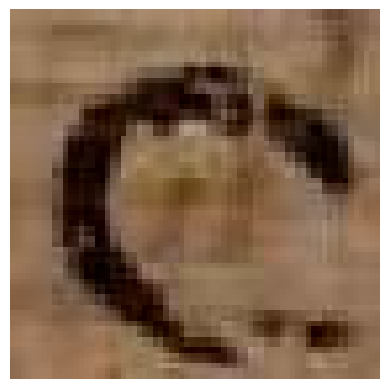

In [24]:
# Display the grayscale image
plt.imshow(X[91637])
plt.axis("off")
plt.show()

In [204]:
X_in = np.array(X_gray)
X_in = X_in.reshape([205797,1, 70, 70])
X_in.shape

(205797, 1, 70, 70)

In [205]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y, test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

In [206]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Test images shape:",X_test.shape)
print("Test labels shape:",Y_test.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (166695, 1, 70, 70)
Train labels shape: (166695, 24)
Test images shape: (20580, 1, 70, 70)
Test labels shape: (20580, 24)
Validation images shape: (18522, 1, 70, 70)
Validation labels shape: (18522, 24)


In [207]:
#ConvAutoencoder Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset

In [208]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [209]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [210]:
train_dataset = CharacterDataset(X_train, Y_train)
test_dataset = CharacterDataset(X_test, Y_test)
val_dataset = CharacterDataset(X_val, Y_val)

In [221]:
#Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.bottleneck = nn.Sequential(
            nn.Linear(128*5*5, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 128*5*5),
            nn.ReLU()
        )
        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.bottleneck(x) # bottleneck layer: 3200 -> latent dim
        #print(x.size())
        x= x.view(x.size(0),128, 5, 5)
        #print(x.size())
        x = self.decoder(x)
        #print(x.size())
        x = x[:,:,:70, :70] # the output of decoder would be 72x72 trimming it to 70x70
        #print(x.size())
        return x

Epoch [1/10], Train Loss: 1060.3369, Test Loss: 995.2281
Epoch [2/10], Train Loss: 1004.9102, Test Loss: 985.8726
Epoch [3/10], Train Loss: 997.5683, Test Loss: 982.2329
Epoch [4/10], Train Loss: 993.5542, Test Loss: 978.4433
Epoch [5/10], Train Loss: 990.6272, Test Loss: 976.8221
Epoch [6/10], Train Loss: 988.9089, Test Loss: 982.9768
Epoch [7/10], Train Loss: 987.0946, Test Loss: 979.2316
Epoch [8/10], Train Loss: 985.4457, Test Loss: 974.8830
Epoch [9/10], Train Loss: 984.0242, Test Loss: 972.7192
Epoch [10/10], Train Loss: 982.5450, Test Loss: 970.5103


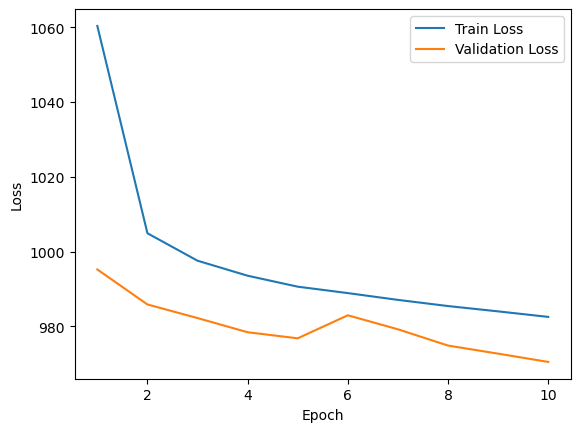

Epoch [1/10], Train Loss: 1363.8038, Test Loss: 1248.7543
Epoch [2/10], Train Loss: 1262.5564, Test Loss: 1239.2222
Epoch [3/10], Train Loss: 900.7522, Test Loss: 748.3614
Epoch [4/10], Train Loss: 753.5288, Test Loss: 746.4891
Epoch [5/10], Train Loss: 747.9309, Test Loss: 738.8521
Epoch [6/10], Train Loss: 743.3387, Test Loss: 740.2393
Epoch [7/10], Train Loss: 739.2791, Test Loss: 734.2419
Epoch [8/10], Train Loss: 735.5112, Test Loss: 728.1610
Epoch [9/10], Train Loss: 732.0900, Test Loss: 727.0167
Epoch [10/10], Train Loss: 728.6652, Test Loss: 724.5302


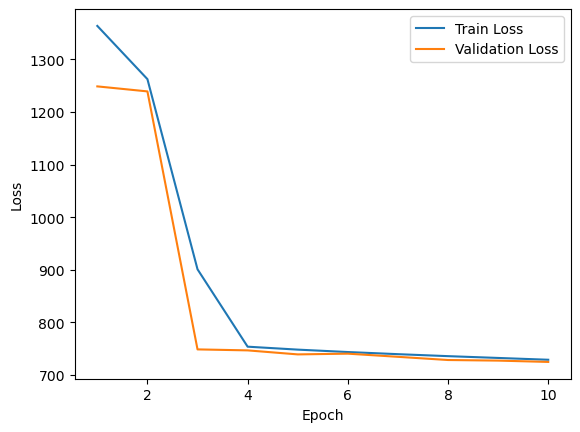

Epoch [1/10], Train Loss: 1203.3392, Test Loss: 1110.4871
Epoch [2/10], Train Loss: 1128.2089, Test Loss: 1111.5935
Epoch [3/10], Train Loss: 1127.1173, Test Loss: 1110.7987
Epoch [4/10], Train Loss: 1126.9470, Test Loss: 1111.0136
Epoch [5/10], Train Loss: 1126.2380, Test Loss: 1110.5028
Epoch [6/10], Train Loss: 1125.9618, Test Loss: 1113.1188
Epoch [7/10], Train Loss: 1125.8163, Test Loss: 1109.8480
Epoch [8/10], Train Loss: 1125.7128, Test Loss: 1109.5407
Epoch [9/10], Train Loss: 1125.6400, Test Loss: 1109.0613
Epoch [10/10], Train Loss: 1125.4099, Test Loss: 1109.2922


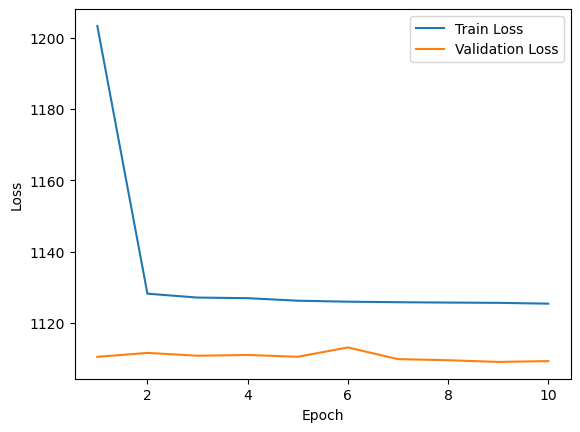

Epoch [1/10], Train Loss: 717.3419, Test Loss: 548.5758
Epoch [2/10], Train Loss: 542.0394, Test Loss: 527.7162
Epoch [3/10], Train Loss: 529.4699, Test Loss: 515.3507
Epoch [4/10], Train Loss: 513.1320, Test Loss: 503.5551
Epoch [5/10], Train Loss: 502.3132, Test Loss: 495.4491
Epoch [6/10], Train Loss: 494.4384, Test Loss: 489.3653
Epoch [7/10], Train Loss: 488.1970, Test Loss: 484.0900
Epoch [8/10], Train Loss: 483.6770, Test Loss: 480.7794
Epoch [9/10], Train Loss: 479.6130, Test Loss: 480.6938
Epoch [10/10], Train Loss: 476.3880, Test Loss: 473.0851


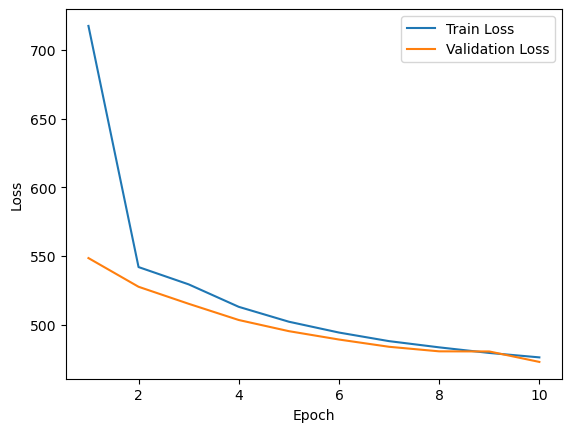

Epoch [1/10], Train Loss: 507.4958, Test Loss: 310.8452
Epoch [2/10], Train Loss: 318.1350, Test Loss: 290.6326
Epoch [3/10], Train Loss: 288.0944, Test Loss: 280.6993
Epoch [4/10], Train Loss: 280.4685, Test Loss: 274.7198
Epoch [5/10], Train Loss: 274.1627, Test Loss: 273.3753
Epoch [6/10], Train Loss: 269.3267, Test Loss: 265.3061
Epoch [7/10], Train Loss: 265.9690, Test Loss: 261.2355
Epoch [8/10], Train Loss: 262.1366, Test Loss: 260.3099
Epoch [9/10], Train Loss: 259.6112, Test Loss: 258.1737
Epoch [10/10], Train Loss: 257.5037, Test Loss: 257.6216


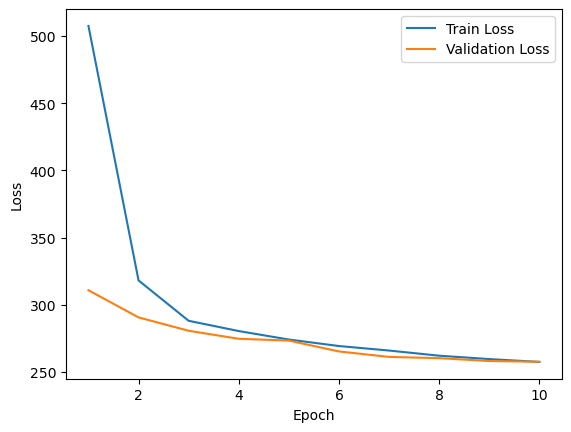

Epoch [1/10], Train Loss: 458.8392, Test Loss: 200.9925
Epoch [2/10], Train Loss: 208.6120, Test Loss: 187.3139
Epoch [3/10], Train Loss: 186.2179, Test Loss: 174.6009
Epoch [4/10], Train Loss: 178.6509, Test Loss: 174.3222
Epoch [5/10], Train Loss: 176.3986, Test Loss: 169.6470
Epoch [6/10], Train Loss: 171.7262, Test Loss: 169.2241
Epoch [7/10], Train Loss: 169.6472, Test Loss: 168.0479
Epoch [8/10], Train Loss: 168.1071, Test Loss: 164.8704
Epoch [9/10], Train Loss: 166.3796, Test Loss: 169.3658
Epoch [10/10], Train Loss: 164.8237, Test Loss: 163.4476


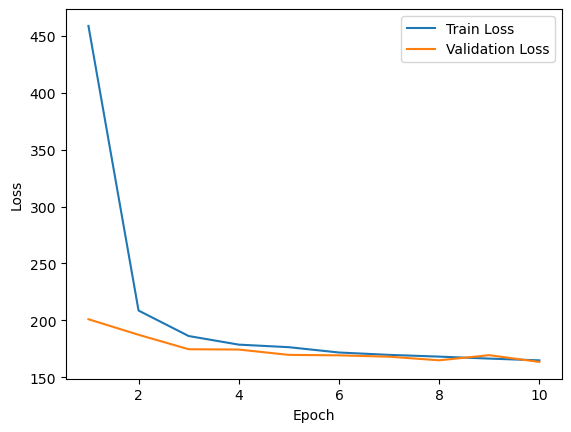

Epoch [1/10], Train Loss: 913.7889, Test Loss: 683.3525
Epoch [2/10], Train Loss: 656.5706, Test Loss: 632.5870
Epoch [3/10], Train Loss: 634.6002, Test Loss: 618.8318
Epoch [4/10], Train Loss: 616.6403, Test Loss: 610.7305
Epoch [5/10], Train Loss: 611.3052, Test Loss: 605.7406
Epoch [6/10], Train Loss: 607.4019, Test Loss: 600.7598
Epoch [7/10], Train Loss: 603.5101, Test Loss: 600.5576
Epoch [8/10], Train Loss: 600.2797, Test Loss: 600.3313
Epoch [9/10], Train Loss: 598.2588, Test Loss: 595.0765
Epoch [10/10], Train Loss: 596.7698, Test Loss: 601.6890


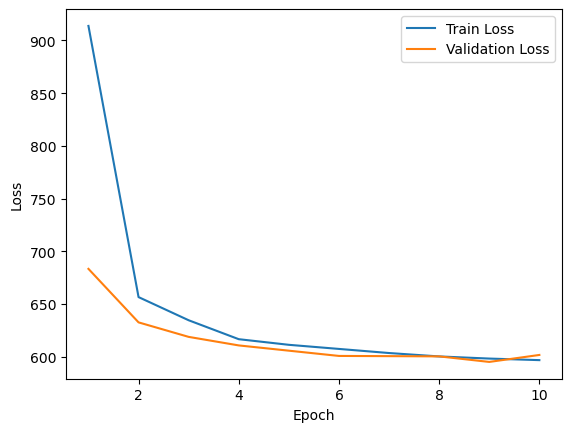

In [225]:
for latent_dim in [2,5,10,25,50,100,500]: # evaluate for [2,5,10,25,50,100,500] latent dims

    model = ConvAutoencoder(latent_dim)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    batch_size = 64

    best_test_loss = float('inf')
    best_model_state = None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0

        # Training
        model.train()
        for batch in train_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch

                # Forward pass
                reconstructions = model(images)
                loss = criterion(reconstructions, images)

                test_loss += loss.item() * images.size(0)

            test_loss /= len(val_loader.dataset)
            test_losses.append(test_loss)

            # Check if current model has the lowest test loss so far
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict().copy()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Plotting train and test loss
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Load the best model state (lowest test loss)
    model.load_state_dict(best_model_state)
    torch.save(model, '../models/alpub_conv_autoencoder_dim_'+str(latent_dim)+'.pt')

Test results for latent dim 2 ...


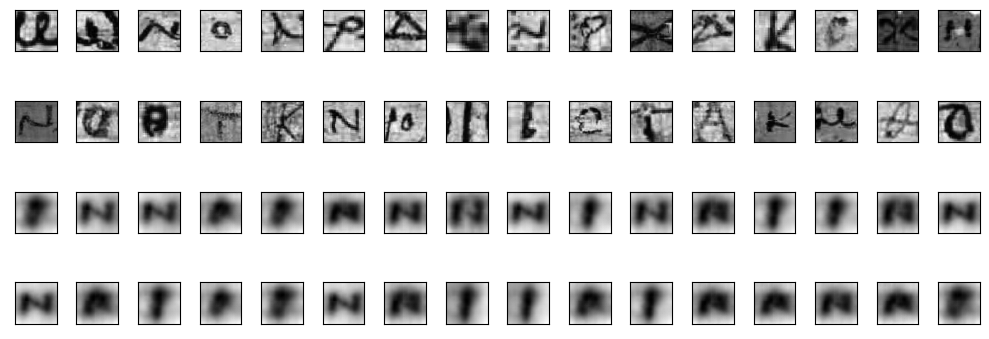

Test results for latent dim 5 ...


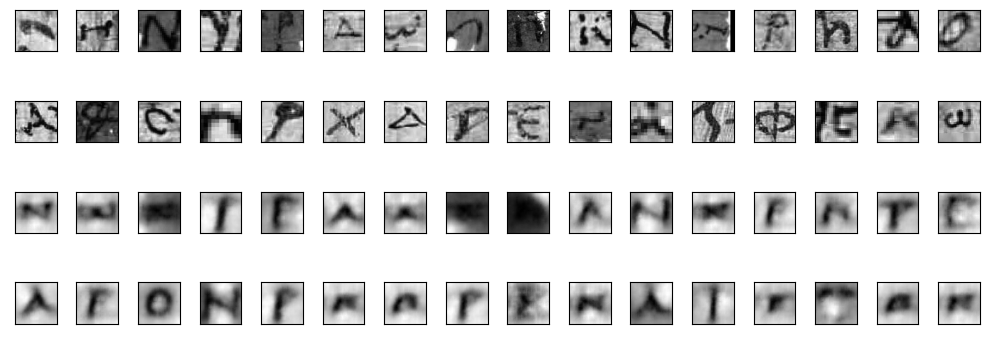

Test results for latent dim 10 ...


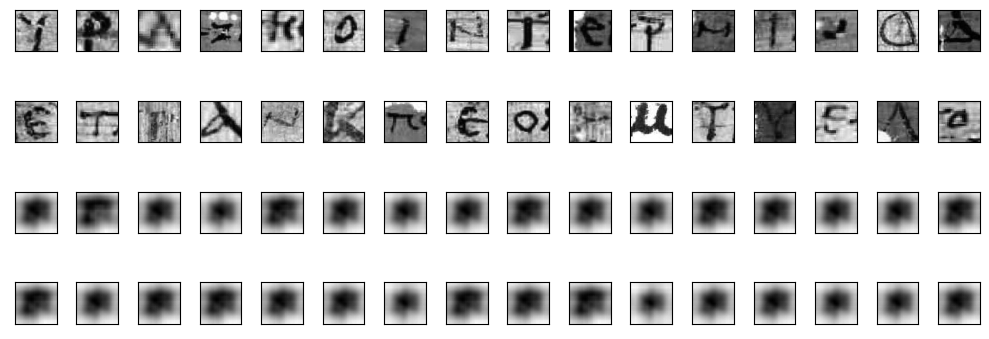

Test results for latent dim 25 ...


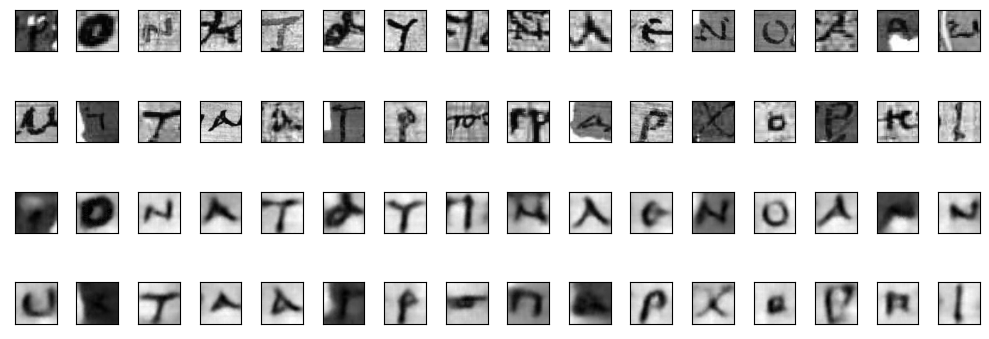

Test results for latent dim 50 ...


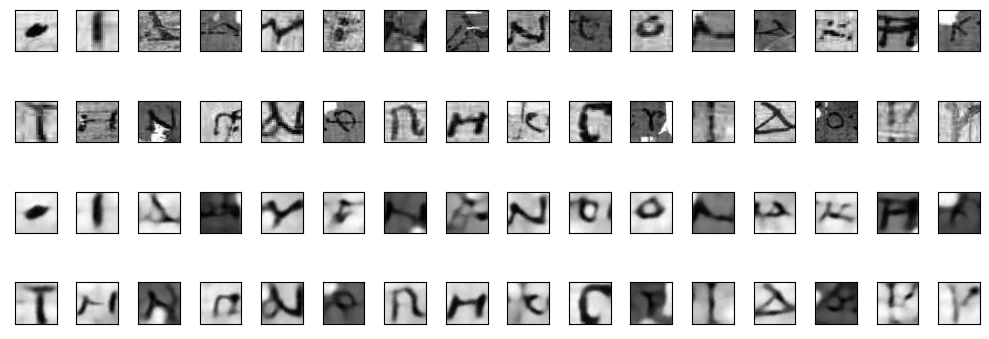

Test results for latent dim 100 ...


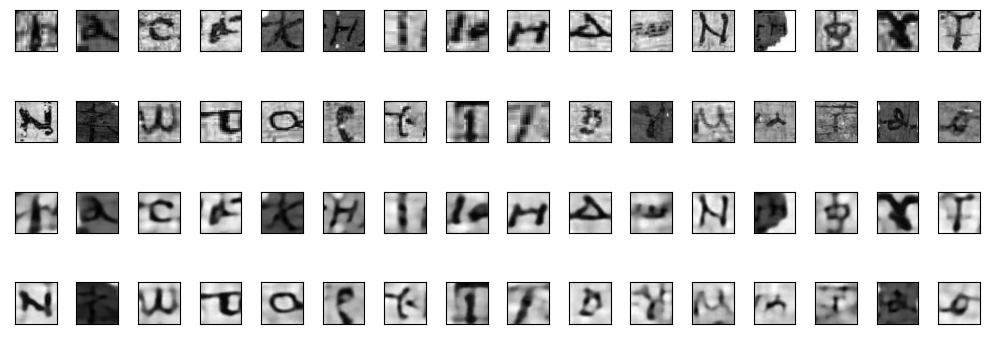

Test results for latent dim 500 ...


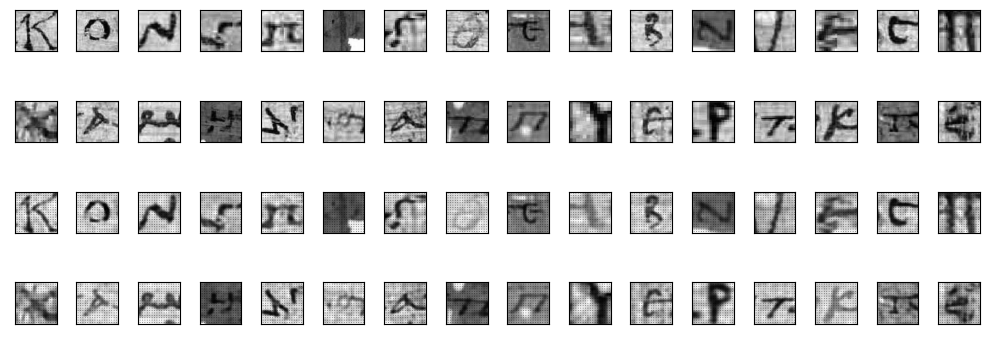

In [227]:
for latent_dim in [2,5,10,25,50,100,500]: # evaluate for [2,5,10,25,50,100,500] latent dims

    print('Test results for latent dim', latent_dim, '...')

    model = torch.load('../models/alpub_conv_autoencoder_dim_'+str(latent_dim)+'.pt')
    # Set the model to evaluation mode
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Get a batch of test data
    test_batch = next(iter(test_loader))
    test_images, _ = test_batch

    # Pass the test data through the model
    with torch.no_grad():
        reconstructions = model(test_images)

    # Plot the original images and their reconstructions
    fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        if i < batch_size // 2:
            # Plot original image
            ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            # Plot reconstructed image
            ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])


    plt.tight_layout()
    plt.show()